In [1]:
_ = """
Model: y = f(x) + epsilon
Task: estimate function f using training data

1) Kernel Regression:
    kernel function
    smoothing parameter

2) Smoothing splines
    smoothing parameter - drugi fragment do minimalizacji jest dla wygładzenia wykresu
"""


In [2]:
import math

from scipy.interpolate import make_smoothing_spline
import matplotlib.pyplot as plt
import numpy as np


# 1. Generate artiifcial data


In [3]:
def g(x: float) -> float:
    return 4.26*(math.e**(-x) - 4*math.e**(-2*x) + 3*math.e**(-3*x))


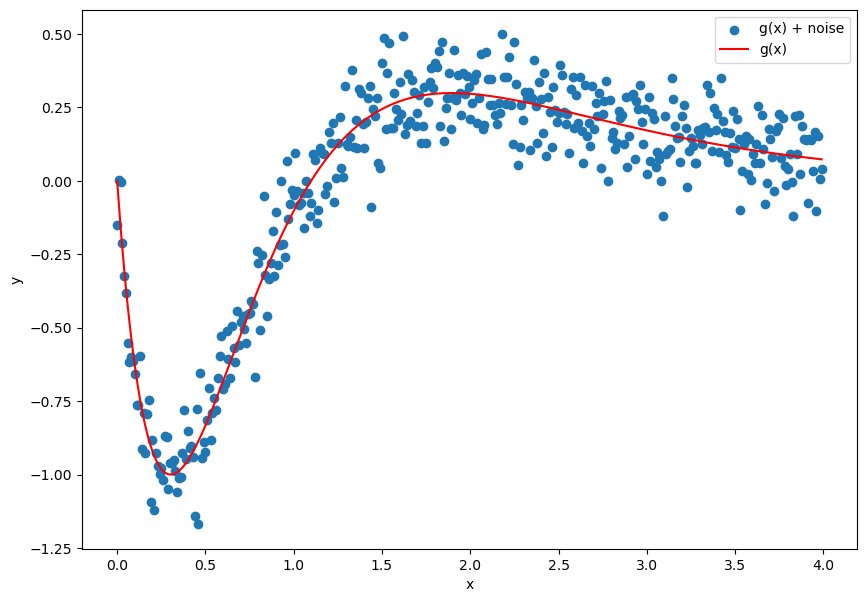

In [4]:
plt.figure(figsize=(10, 7))

x_points = [x/100 for x in range(0, 400)]
y_points = [g(x) for x in x_points]
y_noise = [g(x)+np.random.normal(0, 0.1) for x in x_points]

plt.scatter(x_points, y_noise, label="g(x) + noise")
plt.plot(x_points, y_points, "r", label="g(x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


# 2. Implement from scratch Nadaraya-Watson kernel regression.

In [5]:
def gaussian(x: float, mu: int = 0, sig: int = 1) -> float:
    return (
        1.0 / (np.sqrt(2.0 * np.pi) * sig) *
        np.exp(-np.power((x - mu) / sig, 2.0) / 2)
    )


def tophat(x: float, mu: int = 0, width: int = 1) -> float:
    if abs(x - mu) <= width / 2:
        return 1.0 / width
    else:
        return 0.0


def mean_squared_error(
    true_values: list[float],
    estimated_values: list[float]
    ) -> float:

    true_values = np.asarray(true_values)
    estimated_values = np.asarray(estimated_values)
    
    mse = np.mean((true_values - estimated_values) ** 2)
    return mse


In [6]:
def kernel_regression(
        x_train: list[float],
        y_train: list[float],
        x: float,
        kernel_function: str = "gaussian",
        smoothing_parameter: float = 0.2
        ) -> float:
    """
    Nadaraya-Watson
    """

    if kernel_function == "gaussian":
        kernel_function = gaussian
    elif kernel_function == "tophat":
        kernel_function = tophat
    else:
        raise Exception(f"Idk what is '{kernel_function}' function :/")

    weights = [
        kernel_function((x_train[i]-x)/smoothing_parameter)/smoothing_parameter
        for i in range(len(x_train))
    ]

    return sum([
        weights[i]*y_train[i]
        for i in range(len(x_train))
        ]) / sum(weights)


# 3. Compare the performance of the two algorithms:
#   * Nadaraya-Watson kernel regression,
#   * Smoothing Splines regression.


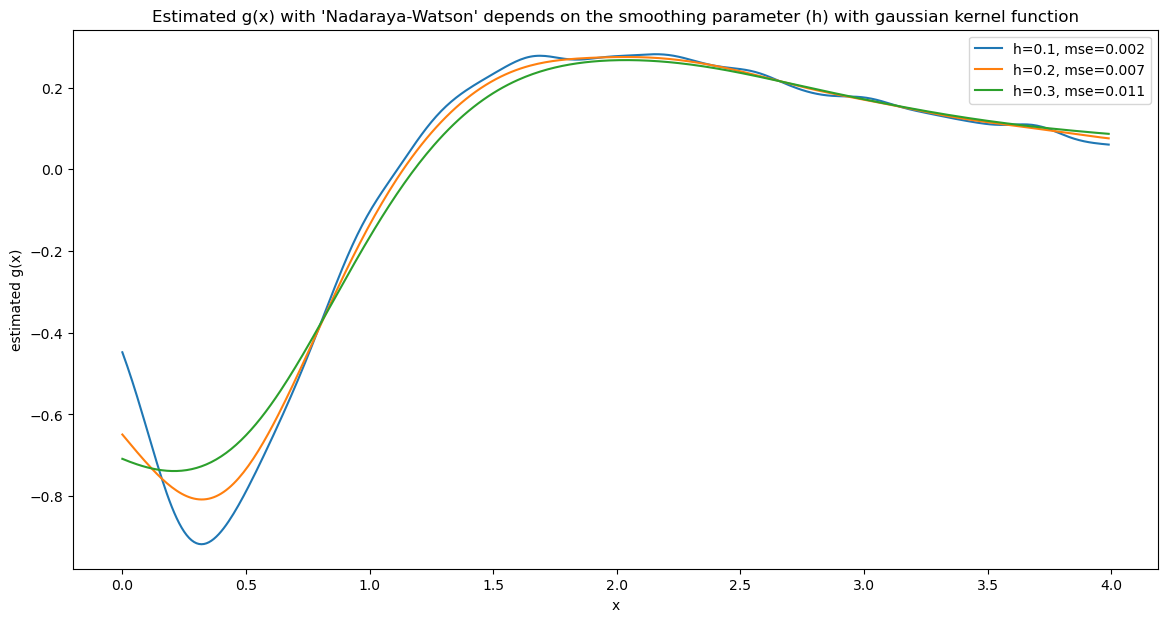

In [7]:
plt.figure(figsize=(14, 7))

x_points = [x/100 for x in range(0, 400)]
y_points = [g(x) for x in x_points]
y_noise = [g(x)+np.random.normal(0, 0.1) for x in x_points]

for smoothing_parameter in [h/10 for h in range(1, 4, 1)]:
    y_pred = [
        kernel_regression(x_points, y_noise, x, "gaussian", smoothing_parameter)
        for x in x_points
        ]

    mse = round(mean_squared_error(y_points, y_pred), 3)

    plt.plot(x_points, y_pred, label=f"h={smoothing_parameter}, mse={mse}")

plt.xlabel("x")
plt.ylabel("estimated g(x)")

title = "Estimated g(x) with 'Nadaraya-Watson' depends on the "
title += "smoothing parameter (h) with gaussian kernel function"
plt.title(title)
plt.legend()
plt.show()


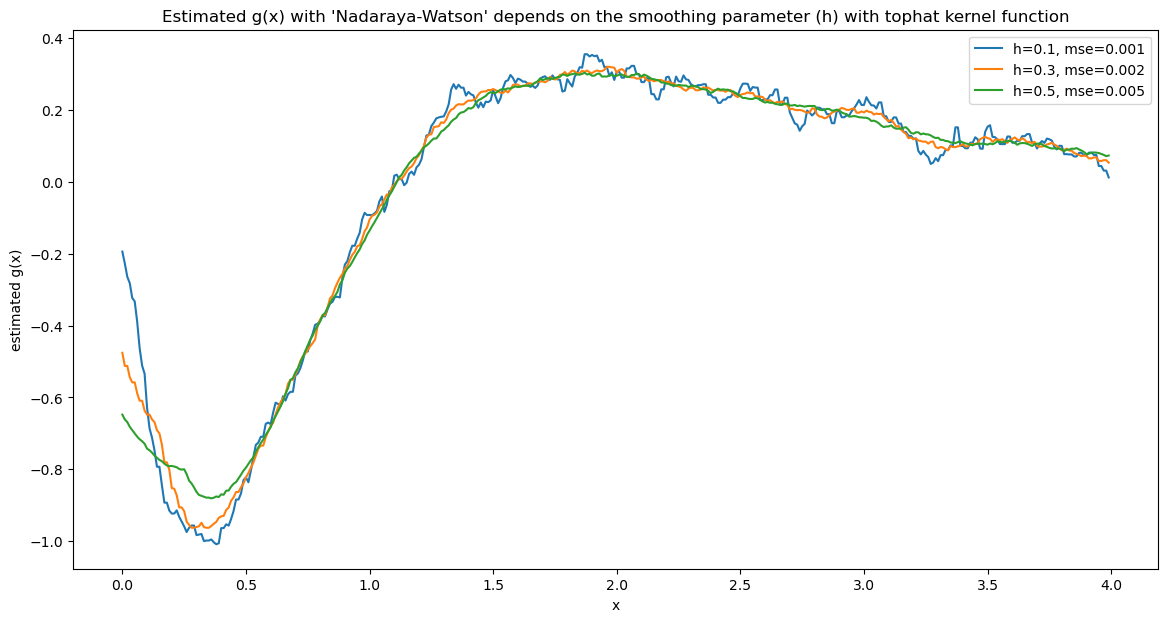

In [8]:
plt.figure(figsize=(14, 7))

x_points = [x/100 for x in range(0, 400)]
y_points = [g(x) for x in x_points]
y_noise = [g(x)+np.random.normal(0, 0.1) for x in x_points]

for smoothing_parameter in [0.1, 0.3, 0.5]:
    y_pred = [
        kernel_regression(x_points, y_noise, x, "tophat", smoothing_parameter)
        for x in x_points
        ]

    mse = round(mean_squared_error(y_points, y_pred), 3)

    plt.plot(x_points, y_pred, label=f"h={smoothing_parameter}, mse={mse}")

plt.xlabel("x")
plt.ylabel("estimated g(x)")

title = "Estimated g(x) with 'Nadaraya-Watson' depends on the "
title += "smoothing parameter (h) with tophat kernel function"
plt.title(title)
plt.legend()
plt.show()


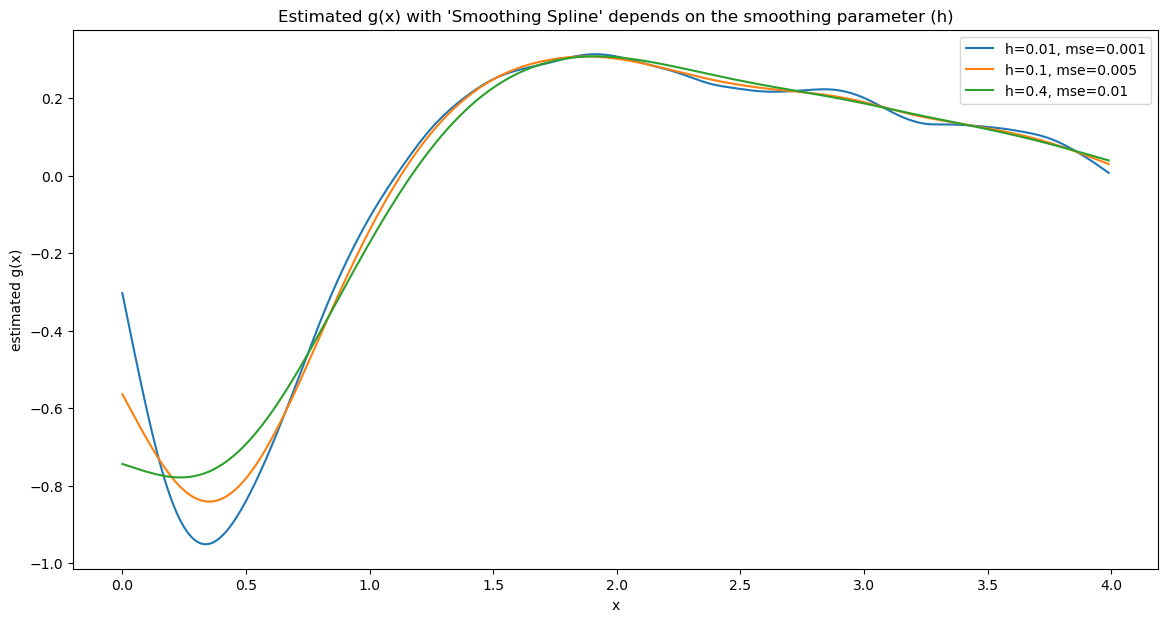

In [9]:
plt.figure(figsize=(14, 7))

x_points = [x/100 for x in range(0, 400)]
y_points = [g(x) for x in x_points]
y_noise = [g(x)+np.random.normal(0, 0.1) for x in x_points]

for smoothing_parameter in [0.01] + [h/10 for h in range(1, 7, 3)]:
    spline = make_smoothing_spline(x_points, y_noise, lam=smoothing_parameter)
    y_pred = spline(x_points)

    mse = round(mean_squared_error(y_points, y_pred), 3)

    plt.plot(x_points, y_pred, label=f"h={smoothing_parameter}, mse={mse}")

plt.xlabel("x")
plt.ylabel("estimated g(x)")
plt.title("Estimated g(x) with 'Smoothing Spline' depends on the smoothing parameter (h)")
plt.legend()
plt.show()


# 4. Visualize the results. Prepare scatter plot and draw the curves corresponding to the true regression function g(x) and to the fitted models.

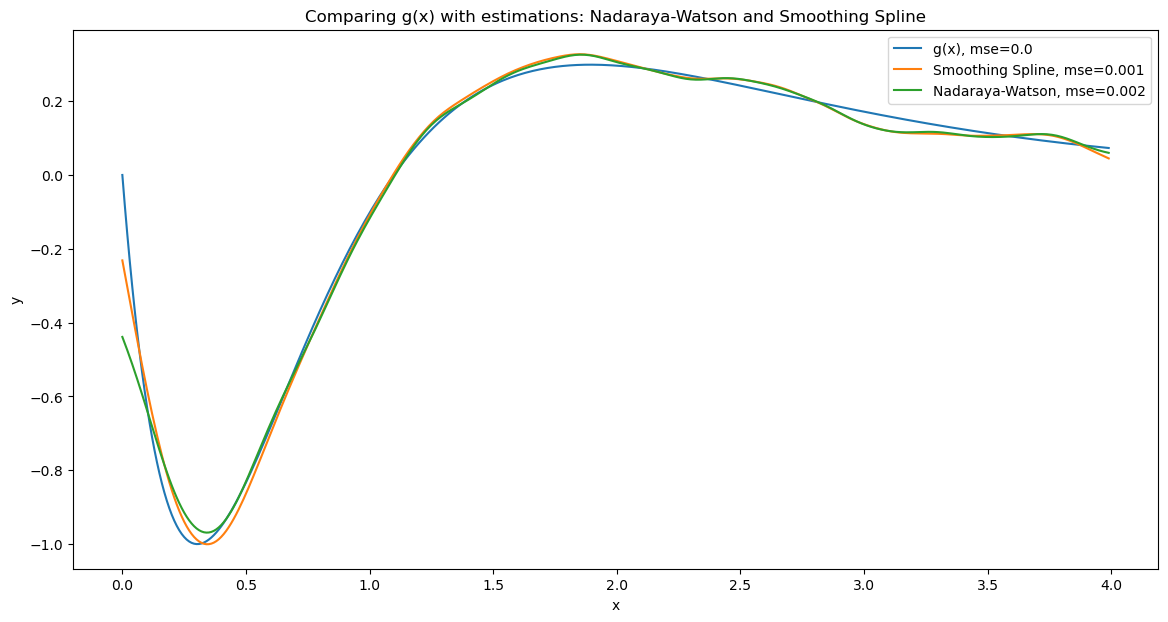

In [10]:
plt.figure(figsize=(14, 7))

x_points = [x/100 for x in range(0, 400)]
y_points = [g(x) for x in x_points]
y_noise = [g(x)+np.random.normal(0, 0.1) for x in x_points]

plt.plot(x_points, y_points, label=f"g(x), mse=0.0")


spline = make_smoothing_spline(x_points, y_noise, lam=0.01)
y_pred = spline(x_points)
mse = round(mean_squared_error(y_points, y_pred), 3)
plt.plot(x_points, y_pred, label=f"Smoothing Spline, mse={mse}")


y_pred = [
    kernel_regression(x_points, y_noise, x, "gaussian", 0.1)
    for x in x_points
    ]
mse = round(mean_squared_error(y_points, y_pred), 3)
plt.plot(x_points, y_pred, label=f"Nadaraya-Watson, mse={mse}")


plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparing g(x) with estimations: Nadaraya-Watson and Smoothing Spline")
plt.legend()
plt.show()


# 5. Compute MSE for the two considered methods.

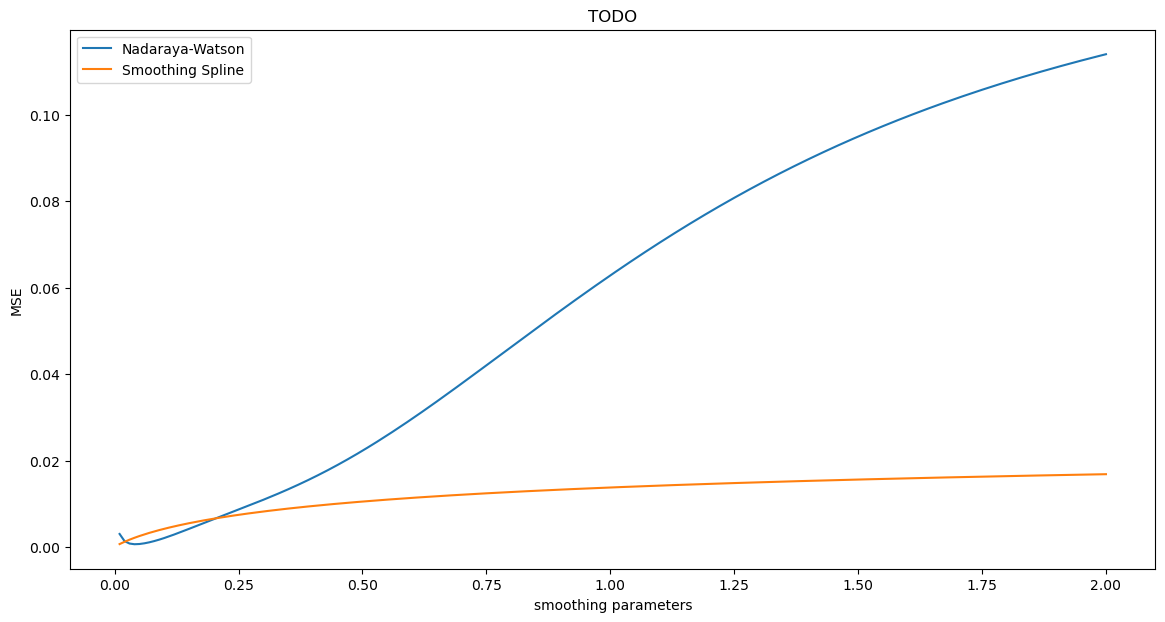

In [11]:
x_points = [x/100 for x in range(0, 400)]
y_points = [g(x) for x in x_points]
y_noise = [g(x)+np.random.normal(0, 0.1) for x in x_points]

results: dict[str, list[float]] = {
    "Smoothing Spline": [],
    "Nadaraya-Watson": []

}
smoothing_parameters = [h/100 for h in range(1, 201)]

for smoothing_parameter in smoothing_parameters:
    spline = make_smoothing_spline(x_points, y_noise, lam=smoothing_parameter)
    y_pred = spline(x_points)
    mse = mean_squared_error(y_points, y_pred)
    results["Smoothing Spline"].append(mse)

    y_pred = [
        kernel_regression(x_points, y_noise, x, "gaussian", smoothing_parameter)
        for x in x_points
        ]
    mse = mean_squared_error(y_points, y_pred)
    results["Nadaraya-Watson"].append(mse)


plt.figure(figsize=(14, 7))
plt.plot(smoothing_parameters, results["Nadaraya-Watson"], label="Nadaraya-Watson")
plt.plot(smoothing_parameters, results["Smoothing Spline"], label="Smoothing Spline")
plt.xlabel("smoothing parameters")
plt.ylabel("MSE")
plt.title("TODO")
plt.legend()
plt.show()


You can see from the image that "Smoothing Spline" gives the worst results for small smoothing parameters, however if you want to use larger numbers it is better because the MSE is close to constants.
Of course you always want to have the lowest MSE so the method is better than Nadaraya-Watson regression.

# 6. Explore how the MSE depends on sample size n. Generate a plot

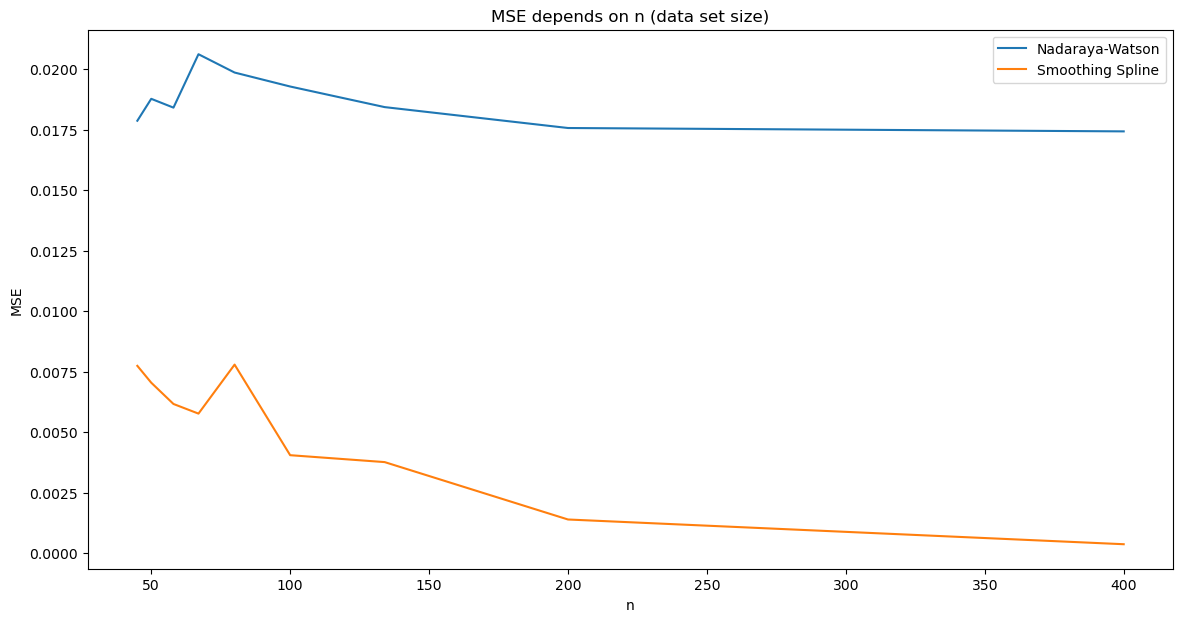

In [12]:
steps = list(range(1, 10))

results: dict[str, list[float]] = {
    "Smoothing Spline": [],
    "Nadaraya-Watson": []

}
how_many = 10


for step in steps:
    x_points = [x/1000 for x in range(0, 400, step)]
    y_points = [g(x) for x in x_points]
    y_noise = [g(x)+np.random.normal(0, 0.1) for x in x_points]

    mse_1 = 0
    mse_2 = 0

    for _ in range(how_many):
        spline = make_smoothing_spline(x_points, y_noise, lam=0.01)
        y_pred = spline(x_points)
        mse = mean_squared_error(y_points, y_pred)
        mse_1 += mse

        y_pred = [
            kernel_regression(x_points, y_noise, x, "gaussian", 0.1)
            for x in x_points
            ]
        mse = mean_squared_error(y_points, y_pred)
        mse_2 += mse
    
    results["Smoothing Spline"].append(mse_1/how_many)
    results["Nadaraya-Watson"].append(mse_2/how_many)


x_ticks = [
    len(list(range(0, 400, step)))
    for step in steps
]
plt.figure(figsize=(14, 7))
plt.plot(x_ticks, results["Nadaraya-Watson"], label="Nadaraya-Watson")
plt.plot(x_ticks, results["Smoothing Spline"], label="Smoothing Spline")
plt.xlabel("n")
plt.ylabel("MSE")
plt.title("MSE depends on n (data set size)")
plt.legend()
plt.show()


You can see that fewer observations mean a higher MSE value - which is correct because the model has less training data and cannot be good enough.

# Save to pdf's

### PLOT1.pdf


In [13]:
from matplotlib.backends.backend_pdf import PdfPages

x_points = [x/100 for x in range(0, 400)]
y_points = [g(x) for x in x_points]
y_noise = [g(x)+np.random.normal(0, 0.1) for x in x_points]

with PdfPages("PLOT1.pdf") as pdf:
    # TOGETHER
    plt.figure(figsize=(14, 7))
    plt.plot(x_points, y_points, label=f"g(x), mse=0.0")

    spline = make_smoothing_spline(x_points, y_noise, lam=0.01)
    y_pred = spline(x_points)
    mse = round(mean_squared_error(y_points, y_pred), 3)
    plt.plot(x_points, y_pred, label=f"Smoothing Spline, mse={mse}")


    y_pred = [
        kernel_regression(x_points, y_noise, x, "gaussian", 0.1)
        for x in x_points
        ]
    mse = round(mean_squared_error(y_points, y_pred), 3)
    plt.plot(x_points, y_pred, label=f"Nadaraya-Watson, mse={mse}")

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Comparing g(x) with estimations: Nadaraya-Watson and Smoothing Spline")
    plt.legend()
    pdf.savefig()
    plt.close()


    # Clear g(x)
    plt.figure(figsize=(14, 7))
    plt.scatter(x_points, y_points, label=f"g(x), mse=0.0")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("g(x) without noise")
    plt.legend()
    pdf.savefig()
    plt.close()


    # Smoothing Spline
    plt.figure(figsize=(14, 7))
    spline = make_smoothing_spline(x_points, y_noise, lam=0.01)
    y_pred = spline(x_points)
    mse = round(mean_squared_error(y_points, y_pred), 3)
    plt.scatter(x_points, y_pred, label=f"Smoothing Spline, mse={mse}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Comparing g(x) with estimation: Smoothing Spline")
    plt.legend()
    pdf.savefig()
    plt.close()


    # Nadaraya-Watson
    plt.figure(figsize=(14, 7))
    y_pred = [
        kernel_regression(x_points, y_noise, x, "gaussian", 0.1)
        for x in x_points
        ]
    mse = round(mean_squared_error(y_points, y_pred), 3)
    plt.scatter(x_points, y_pred, label=f"Nadaraya-Watson, mse={mse}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Comparing g(x) with estimation: Nadaraya-Watson")
    plt.legend()
    pdf.savefig()
    plt.close()


### PLOT2.pdf


In [14]:
steps = list(range(1, 10))

results: dict[str, list[float]] = {
    "Smoothing Spline": [],
    "Nadaraya-Watson": []

}
how_many = 10


for step in steps:
    x_points = [x/1000 for x in range(0, 400, step)]
    y_points = [g(x) for x in x_points]
    y_noise = [g(x)+np.random.normal(0, 0.1) for x in x_points]

    mse_1 = 0
    mse_2 = 0

    for _ in range(how_many):
        spline = make_smoothing_spline(x_points, y_noise, lam=0.01)
        y_pred = spline(x_points)
        mse = mean_squared_error(y_points, y_pred)
        mse_1 += mse

        y_pred = [
            kernel_regression(x_points, y_noise, x, "gaussian", 0.1)
            for x in x_points
            ]
        mse = mean_squared_error(y_points, y_pred)
        mse_2 += mse
    
    results["Smoothing Spline"].append(mse_1/how_many)
    results["Nadaraya-Watson"].append(mse_2/how_many)


x_ticks = [
    len(list(range(0, 400, step)))
    for step in steps
]
with PdfPages("PLOT2.pdf") as pdf:
    plt.figure(figsize=(14, 7))
    plt.plot(x_ticks, results["Nadaraya-Watson"], label="Nadaraya-Watson")
    plt.plot(x_ticks, results["Smoothing Spline"], label="Smoothing Spline")
    plt.xlabel("n")
    plt.ylabel("MSE")
    plt.title("MSE depends on n (data set size)")
    plt.legend()
    pdf.savefig()
    plt.close()
